In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from ipykernel import kernelapp as app
from scipy import stats
import json
import pickle

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, ShuffleSplit
from sklearn.metrics import mean_absolute_error
from sklearn.utils import resample

from tensorflow import keras
from keras import Sequential, optimizers
from keras.models import Model, model_from_json, Sequential
from keras.layers import Dense, Input, BatchNormalization, Dropout
from keras.callbacks import ReduceLROnPlateau

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

import BoostedIGA as BIGA
import basedline as bs

/Users/zosmex/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/zosmex/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/zosmex/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/zosmex/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework

In [2]:
from sklearn.datasets import load_boston
boston_dataset = load_boston()
boston_df = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston_df['MEDV'] = boston_dataset.target

X = boston_df.drop(['MEDV'], axis = 1)
y = boston_df.drop(X.columns, axis = 1)


In [3]:
#Normalize

X_norm = MinMaxScaler().fit_transform(X)
X = pd.DataFrame(data = X_norm, columns = X.columns)

# Hyperparameter tuning

In this experiment, we use grid search to find optimal parameter

In [4]:

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from keras.wrappers.scikit_learn import KerasRegressor

scoring = {
    'MAAPE':make_scorer(BIGA.mean_arctan_absolute_percentage_error, greater_is_better=False),
    'MSE':'neg_mean_squared_error'}

def grid_model(n=13, optimizer='adam', learning_rate = 0.001):
    inputs = Input(shape=(n,))
    h_1 = Dense(100, kernel_initializer='he_normal', activation='linear',bias_initializer='zeros')(inputs)
    #h[1] = BatchNormalization()(h[0])
    outputs = Dense(1, kernel_initializer='he_normal',bias_initializer='zeros')(h_1)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    adam = optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss='mean_squared_error', optimizer=adam)
    #print(model.summary())
    return model


model = keras.wrappers.scikit_learn.KerasRegressor(build_fn=grid_model,
                        epochs=10, 
                        batch_size=5,
                        verbose=0)


param_grid = {'epochs':[50,100,150],
              'batch_size':[16,32,64]}

grid = GridSearchCV(model,
                    param_grid=param_grid,
                    return_train_score=True,
                    scoring=scoring,
                    refit = 'MSE')

grid_results = grid.fit(X, y)

print('Parameters of the best model: ')
print(grid_results.best_params_)

/Users/zosmex/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/zosmex/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Parameters of the best model: 
{'batch_size': 16, 'epochs': 150}


In [ ]:
print(f'Best Accuracy for {grid_results.best_score_:.4} using {grid_results.best_params_}')
means = grid_results.cv_results_['mean_score_time']
stds = grid_results.cv_results_['std_score_time']
params = grid_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f'mean={mean:.4}, std={stdev:.4} using {param}')

# Method comparison

We compare plot each result in final notebook including 4 results from a non-selection model and 3 feature selection model.

- BIGA
- RFE
- RLF


### Non-selection model baseline

In [10]:
model, ss_maape, ss_rmse = BIGA.train_Shuffle(
                                        X, y, 
                                        batch_size=grid_results.best_params_['batch_size'], 
                                        epochs = grid_results.best_params_['epochs'],
                                        n_split = 5
                                        )

print("Avg MAAPE: %.5f%% (+/- %.3f%%)" % (np.mean(ss_maape), np.std(ss_maape)))
print("Avg RMSE: %.5f%% (+/- %.3f%%)" % (np.mean(ss_rmse), np.std(ss_rmse)))


Avg MAAPE: 79.76766% (+/- 1.687%)
Avg RMSE: 25.59027% (+/- 0.592%)


### Boosted Improved Garson's Algorithm (BIGA)

In [11]:
#Method processing

MAAPE_BIGA, RMSE_BIGA, Best_BIGA = BIGA.BoostedIGA(X,y, 
                                                      n_batch_size = grid_results.best_params_['batch_size'],
                                                      n_epochs = grid_results.best_params_['epochs'])



Feature Selection x Boosting >>> Iteration: 1
Feature Selection Process: 1
Selected Feature:  Index(['RM'], dtype='object')
Avg MAAPE: 78.41423% (+/- 2.65546%)
Avg RMSE: 25.17336% (+/- 1.42359%)
Feature Selection x Boosting >>> Iteration: 2
Feature Selection Process: 2
Selected Feature:  Index(['RM', 'PTRATIO'], dtype='object')
Avg MAAPE: 78.96530% (+/- 2.98160%)
Avg RMSE: 25.45328% (+/- 0.79615%)
Feature Selection x Boosting >>> Iteration: 3
Feature Selection Process: 3
Selected Feature:  Index(['INDUS', 'RM', 'PTRATIO'], dtype='object')
Avg MAAPE: 77.36275% (+/- 3.19568%)
Avg RMSE: 24.70534% (+/- 1.33553%)
Feature Selection x Boosting >>> Iteration: 4
Feature Selection Process: 4
Selected Feature:  Index(['INDUS', 'RM', 'RAD', 'PTRATIO'], dtype='object')
Avg MAAPE: 79.60433% (+/- 2.43751%)
Avg RMSE: 25.56559% (+/- 0.85958%)
Feature Selection x Boosting >>> Iteration: 5
Feature Selection Process: 5
Selected Feature:  Index(['INDUS', 'RM', 'RAD', 'PTRATIO', 'B'], dtype='object')
Avg MA

/Users/zosmex/project/BoostedIGA.py:61: RuntimeWarning: invalid value encountered in double_scalars
  s += (cw[i][j] * x[p][i]) / cw_h[p][j]


Avg MAAPE: 77.34544% (+/- 1.65413%)
Avg RMSE: 24.78171% (+/- 0.49164%)


In [ ]:
plt.scatter(range(1,X.shape[1]+1), MAAPE_BIGA)


### Recursive Feature Elimination

In [6]:
MAAPE_RFE, RMSE_RFE, Best_RFE = bs.RFE_model(X,y,
                                            n_batch_size = grid_results.best_params_['batch_size'],
                                            n_epochs = grid_results.best_params_['epochs']
                                            )


Ite : 1


/Users/zosmex/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Index(['RM'], dtype='object')
Avg MAAPE: 78.48% (+/- 3.65%)
Avg RMSE: 25.22% (+/- 1.52%)
Ite : 2
Index(['RM', 'LSTAT'], dtype='object')


/Users/zosmex/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Avg MAAPE: 77.45% (+/- 2.54%)
Avg RMSE: 24.73% (+/- 0.73%)
Ite : 3
Index(['RM', 'PTRATIO', 'LSTAT'], dtype='object')


/Users/zosmex/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Avg MAAPE: 78.99% (+/- 2.02%)
Avg RMSE: 25.55% (+/- 0.72%)
Ite : 4
Index(['RM', 'DIS', 'PTRATIO', 'LSTAT'], dtype='object')


/Users/zosmex/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Avg MAAPE: 78.73% (+/- 2.13%)
Avg RMSE: 25.37% (+/- 0.75%)
Ite : 5
Index(['NOX', 'RM', 'DIS', 'PTRATIO', 'LSTAT'], dtype='object')


/Users/zosmex/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Avg MAAPE: 80.03% (+/- 1.29%)
Avg RMSE: 25.69% (+/- 0.87%)
Ite : 6
Index(['CRIM', 'NOX', 'RM', 'DIS', 'PTRATIO', 'LSTAT'], dtype='object')


/Users/zosmex/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Avg MAAPE: 79.03% (+/- 2.96%)
Avg RMSE: 25.31% (+/- 1.31%)
Ite : 7


/Users/zosmex/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Index(['CRIM', 'NOX', 'RM', 'DIS', 'RAD', 'PTRATIO', 'LSTAT'], dtype='object')
Avg MAAPE: 77.56% (+/- 2.57%)
Avg RMSE: 25.04% (+/- 1.01%)
Ite : 8
Index(['CRIM', 'NOX', 'RM', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'LSTAT'], dtype='object')


/Users/zosmex/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Avg MAAPE: 78.33% (+/- 1.61%)
Avg RMSE: 25.00% (+/- 0.80%)
Ite : 9
Index(['CRIM', 'ZN', 'NOX', 'RM', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'LSTAT'], dtype='object')


/Users/zosmex/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Avg MAAPE: 77.72% (+/- 2.25%)
Avg RMSE: 24.80% (+/- 1.01%)
Ite : 10
Index(['CRIM', 'ZN', 'NOX', 'RM', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B',
       'LSTAT'],
      dtype='object')


/Users/zosmex/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Avg MAAPE: 77.44% (+/- 1.70%)
Avg RMSE: 24.89% (+/- 0.68%)
Ite : 11
Index(['CRIM', 'ZN', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B',
       'LSTAT'],
      dtype='object')


/Users/zosmex/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Avg MAAPE: 77.79% (+/- 2.10%)
Avg RMSE: 25.00% (+/- 0.74%)
Ite : 12
Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')


/Users/zosmex/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Avg MAAPE: 79.70% (+/- 2.34%)
Avg RMSE: 25.60% (+/- 1.01%)
Ite : 13
Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')


/Users/zosmex/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Avg MAAPE: 79.13% (+/- 1.35%)
Avg RMSE: 25.43% (+/- 0.60%)


### Regression RelieF

In [13]:
MAAPE_RLF, RMSE_RLF, Best_RLF = bs.RLF_model(X,y,
                                            n_batch_size = grid_results.best_params_['batch_size'],
                                            n_epochs = grid_results.best_params_['epochs']
                                            )

Iteration:  1
Avg MAAPE: 78.48% (+/- 0.23%)
Avg RMSE: 25.13% (+/- 0.52%)
Iteration:  2
Avg MAAPE: 79.24% (+/- 2.10%)
Avg RMSE: 25.45% (+/- 1.02%)
Iteration:  3
Avg MAAPE: 76.61% (+/- 1.59%)
Avg RMSE: 24.62% (+/- 0.66%)
Iteration:  4
Avg MAAPE: 77.63% (+/- 2.24%)
Avg RMSE: 24.98% (+/- 1.09%)
Iteration:  5
Avg MAAPE: 80.59% (+/- 1.19%)
Avg RMSE: 25.79% (+/- 0.25%)
Iteration:  6
Avg MAAPE: 76.73% (+/- 1.81%)
Avg RMSE: 24.70% (+/- 0.86%)
Iteration:  7
Avg MAAPE: 78.53% (+/- 3.27%)
Avg RMSE: 25.25% (+/- 1.40%)
Iteration:  8
Avg MAAPE: 79.21% (+/- 1.30%)
Avg RMSE: 25.44% (+/- 0.54%)
Iteration:  9
Avg MAAPE: 79.61% (+/- 1.26%)
Avg RMSE: 25.46% (+/- 0.38%)
Iteration:  10
Avg MAAPE: 77.18% (+/- 2.50%)
Avg RMSE: 24.87% (+/- 1.08%)
Iteration:  11
Avg MAAPE: 77.85% (+/- 2.70%)
Avg RMSE: 25.05% (+/- 0.69%)
Iteration:  12
Avg MAAPE: 80.71% (+/- 4.70%)
Avg RMSE: 26.07% (+/- 1.61%)
Iteration:  13
Avg MAAPE: 79.67% (+/- 1.97%)
Avg RMSE: 25.45% (+/- 0.88%)


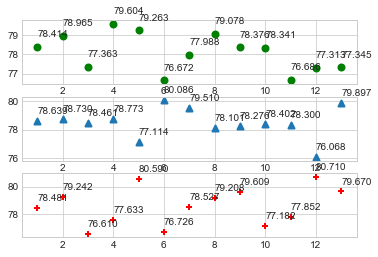

In [14]:
x_plt = range(1,X.shape[1]+1)
y1 = MAAPE_BIGA
y2 = MAAPE_RFE
y3 = MAAPE_RLF

plt.style.use('seaborn-whitegrid')

fig, ax = plt.subplots(3)
ax[0].scatter(x_plt, y1, linewidth=2, c='green')
ax[1].scatter(x_plt, y2, linewidth=2, marker = '^')
ax[2].scatter(x_plt, y3, linewidth=2, c='red', marker = '+')

for i, txt in enumerate(y1):
    ax[0].annotate(s='%.3f'%y1[i], xy=(x_plt[i], y1[i]), xytext =(x_plt[i], y1[i]+0.5))
    ax[1].annotate(s='%.3f'%y2[i], xy=(x_plt[i], y2[i]), xytext =(x_plt[i], y2[i]+0.5))
    ax[2].annotate(s='%.3f'%y3[i], xy=(x_plt[i], y3[i]), xytext =(x_plt[i], y3[i]+0.5))